# Script for generating graphs for KAE EnKF Paper section 4.2: Latent state vs full state KAE EnKF

In [9]:
#Copy this script and then edit to make specific to your dataset for parameter tweaking
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
import seaborn as sb

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
from scipy.sparse.linalg import svds
import cmath
from sklearn.preprocessing import PolynomialFeatures
import itertools
from scipy.stats import gaussian_kde

from libraries.KAE import KoopmanAE, KEDcoder, LinearKoopmanLayer, LuschLoss, gen_jordan_rotation_matrix
from libraries.DMDEnKF import EnKF
import simple_sin_helpers as ssf

### Show example synthetic data

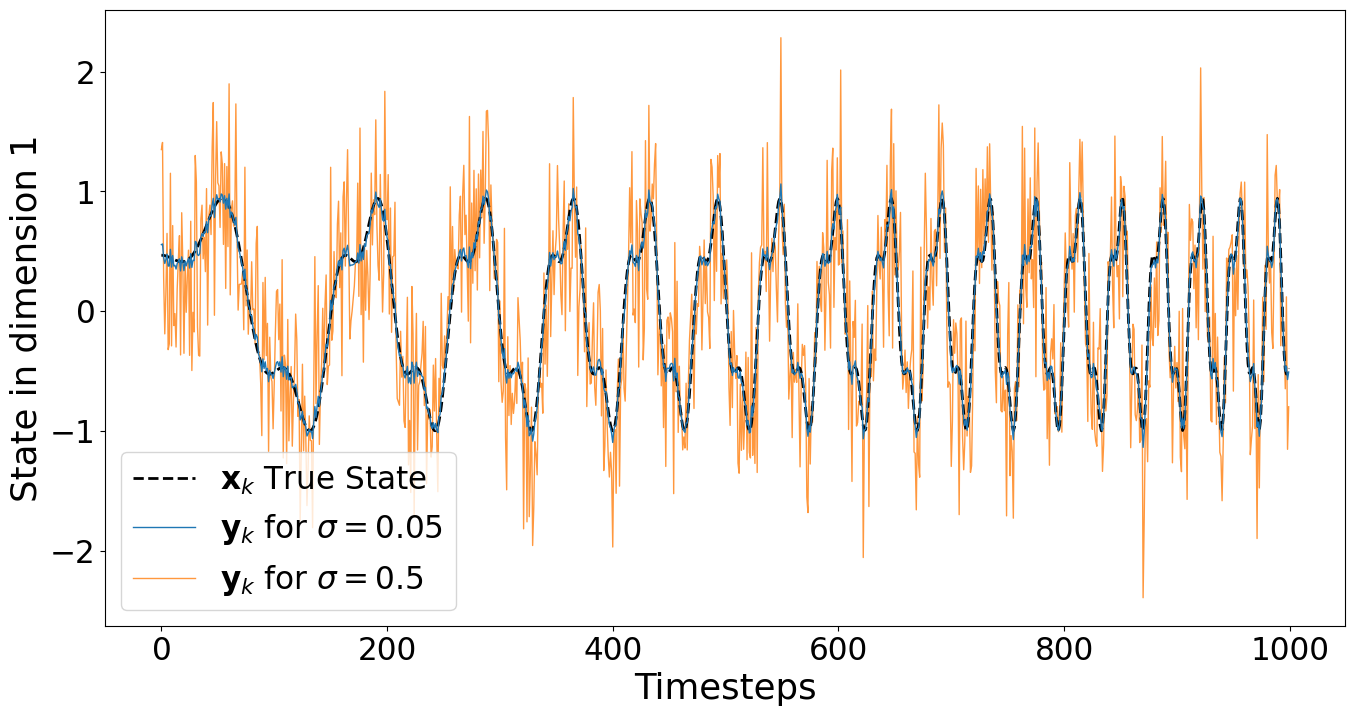

In [10]:
#example noise data plot

#data generation
num_data = 1000
num_spinup = 200
theta_start = np.pi/128
#theta_start = np.pi/32
#theta_end = np.pi/32
theta_end = np.pi/16
r_start = 1
r_end = 1
obs_cov = 0.05**2
data_dim = 100
power = 3

#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

#dataset and dataloaders
dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)

#do this again to ensure randomly generated measurment operator is the same for both (for graph purposes)
torch.manual_seed(0)
np.random.seed(0)
#dataset and dataloaders
highnoise_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,0.5**2,data_dim,power)

plt.plot(dataset.true_highdim_data.T[0], label =r'$\mathbf{x}_k$ True State',alpha = 1, linewidth=2, ls='--',color='black',zorder=5)
plt.plot(dataset.data.T[0],alpha=1, color='tab:blue',zorder=10,label=r'$\mathbf{y}_k$ for $\sigma = 0.05$',linewidth=1)
plt.plot(highnoise_dataset.data.T[0],alpha=0.8,color='tab:orange', label=r'$\mathbf{y}_k$ for $\sigma = 0.5$',linewidth='1')
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
#plt.savefig('graphs/sin5_bothnoise_data_time_series.png',bbox_inches='tight')

## Generate forecasts for both latent and full state KAE EnKF

In [3]:
'''#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

pickle_dic = []
#with open(f'pickles/fullstate_latentstate_kaeenkf_preds_nonlinear_sin.pkl', 'rb') as f:
#    pickle_dic = pickle.load(f)
for i in range(100):
    print(i)
    #dataset and dataloaders
    dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)


    rank = 2
    window_size = 10
    system_cov_const = 0.05**2
    obs_cov_const = obs_cov

    eig_cov_const = 0.005**2

    #standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

    #ALL PARAMETERS

    #KAE variables
    input_size = data_dim    #hardsin uses 100
    num_frequencies = 1    #hard2sin uses 2
    intermid_size = 10
    encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,num_frequencies*2)])
    decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,input_size)])

    #training
    batch_size = 64
    epochs = 100
    global_fourier_interval = 10
    print_interval = 10


    #dataset and dataloaders
    train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

    #No validation set for this example
    #val_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)
    #val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
    val_dataloader = None

    #initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
    kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list)
    lossfunc = LuschLoss
    #this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
    #standard, linear, reconstruction, amplitude stability, regularisation
    loss_hyperparameters = [1,1,1,1,0.01]
    opt = optim.AdamW(kae.parameters(),lr=0.01)
    '''No svd init used in this example due to lower dimension of input data than layer size'''
    U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
    U = torch.from_numpy(U.astype(np.float32).copy())
    kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

    #Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    kae = kae.to(dev)
    kae.device = dev
    kae.linear_koopman_layer.device = dev

    #TRAINING LOOP
    kae.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

    sys_cov_const = 0.05**2
    param_cov_consts = np.array([0.0005**2,0.005**2])
    obs_cov_const = obs_cov
    init_cov_const = obs_cov_const

    kaeenkf = ssf.apply_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)
        
    kaeenkf2 = ssf.apply_fullstate_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)

    p_step = 10
    num_to_keep = num_data-num_spinup
    
    #store predictions adjusted to same length, and aligned with data
    kaeenkf_preds = np.vstack([ssf.kaeenkf_ensembles_p_step_pred(kae,ensemble,p_step)
                               for ensemble in kaeenkf.ensembles])[-num_to_keep:-p_step]

    kaeenkf2_preds = np.vstack([ssf.kaeenkf_fullstate_ensembles_p_step_pred(kae,ensemble,p_step)
                               for ensemble in kaeenkf2.ensembles])[-num_to_keep:-p_step]

    true_values = np.array(dataset.true_highdim_data[-(num_to_keep-p_step):])

    pickles = [true_values, kaeenkf_preds, kaeenkf2_preds]
    pickle_dic.append(pickles)
    with open(f'pickles/fullstate_latentstate_kaeenkf_preds_nonlinear_sin.pkl', 'wb') as f:
        pickle.dump(pickle_dic, f)'''

0
0
tensor([1.])
tensor([0.6993])
First Choice: 0.25160697559339834
New Frequency: 0.25160697559339834
Train Loss: 1.9086424708366394
10
tensor([1.0009])
tensor([-0.0038])
Train Loss: 0.6581966876983643
First Choice: 6.265712600541156
New Frequency: 6.265712600541156
20
tensor([0.9981])
tensor([6.2862])
Train Loss: 0.25933102890849113
First Choice: 0.06290174389834959
New Frequency: 0.06290174389834959
30
tensor([0.9986])
tensor([0.0433])
Train Loss: 0.24158162996172905
First Choice: 0.03145087194917479
New Frequency: 0.03145087194917479
40
tensor([0.9994])
tensor([0.0296])
Train Loss: 0.15402746573090553
50
tensor([0.9995])
tensor([0.0388])
Train Loss: 0.0934820082038641
First Choice: 0.038439954604546966
New Frequency: 0.038439954604546966
60
tensor([0.9968])
tensor([0.0370])
Train Loss: 0.08636058121919632
70
tensor([1.0001])
tensor([0.0382])
Train Loss: 0.06909875199198723
First Choice: 0.04193449593223306
New Frequency: 0.04193449593223306
80
tensor([0.9986])
tensor([0.0433])
Trai

Exception ignored in: <function _on_type_disposal at 0x7fbaf92f5ca0>
Traceback (most recent call last):
  File "/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/numba/core/types/abstract.py", line 27, in _on_type_disposal
    def _on_type_disposal(wr, _pop=_typecache.pop):
KeyboardInterrupt: 

KeyboardInterrupt



### View forecast error distributions for both KAE EnKF

In [11]:
with open(f'pickles/fullstate_latentstate_kaeenkf_preds_nonlinear_sin.pkl', 'rb') as f:
    pickle_dic = pickle.load(f)
    
pickle_dic = np.hstack(pickle_dic)

true_values = pickle_dic[0]
dists = []
for preds in pickle_dic[1:]:
    dist = [(np.linalg.norm(pred-truth)**2)/len(truth) for pred,truth in zip(preds,true_values)]
    dists.append(dist)

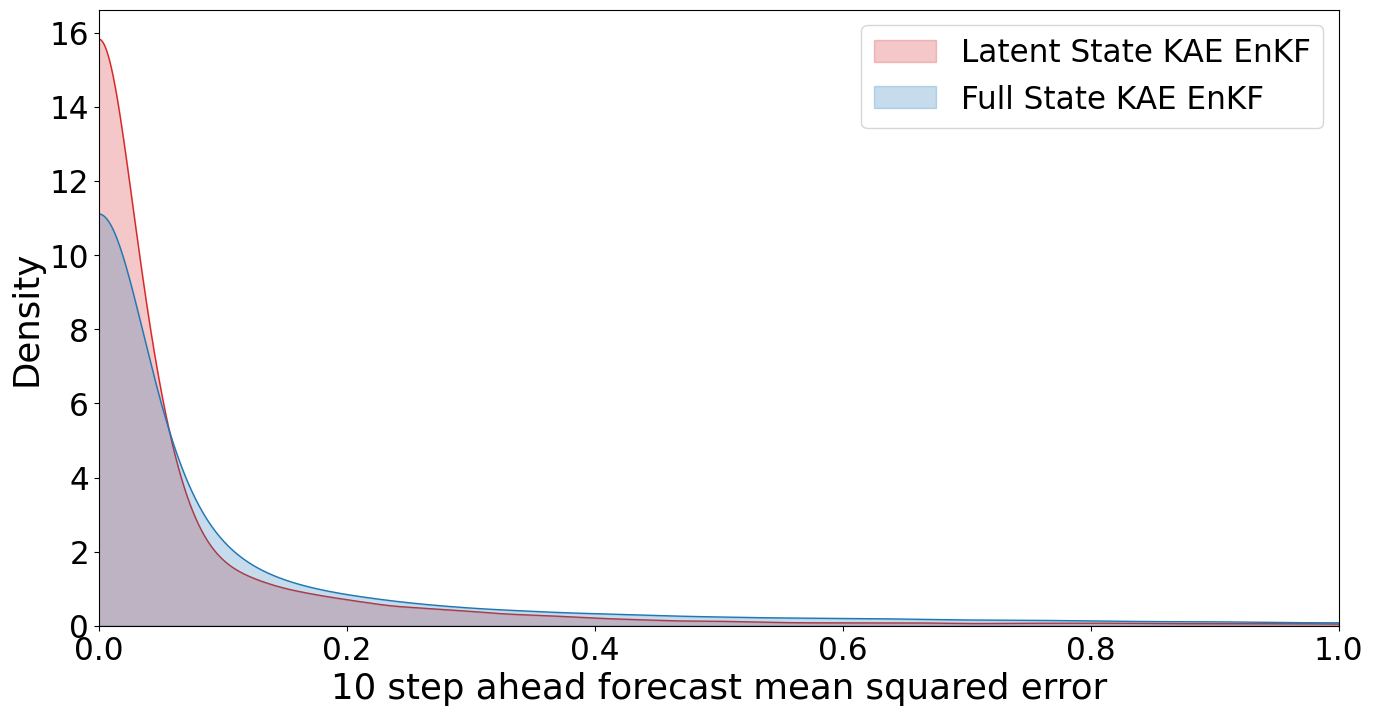

In [12]:
x_lim = 1
num_points = 10000
cols = ['tab:red', 'tab:blue']
labs = ['Latent State KAE EnKF', 'Full State KAE EnKF']
zorders = [1,2]
#dist_max = max([i for j in dists for i in j])
x = np.linspace(0,x_lim,num_points)
for i,dist in enumerate(dists):
    kde = gaussian_kde(dist)
    boundary_reflect_kde = (kde(x)+kde(-x))
    plt.plot(x,boundary_reflect_kde,c=cols[i],linewidth=1,zorder=zorders[i])
    plt.fill_between(x,boundary_reflect_kde,0,alpha=0.25,color=cols[i],
                     label=labs[i],zorder=zorders[i])
plt.xlabel('10 step ahead forecast mean squared error')
plt.ylabel('Density')
plt.ylim(0)
plt.xlim(0,x_lim)
plt.legend()
#plt.savefig('graphs/latent_fullstate_kaeenkf_forecast_mse_dist.png',bbox_inches='tight')

### Run models again to generate eigenvalue modulus and argument trajectories

In [13]:
#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

#dataset and dataloaders
dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)


rank = 2
window_size = 10
system_cov_const = 0.05**2
obs_cov_const = obs_cov

eig_cov_const = 0.005**2

#standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

#ALL PARAMETERS

#KAE variables
input_size = data_dim    #hardsin uses 100
num_frequencies = 1    #hard2sin uses 2
intermid_size = 10
encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,input_size)])

#training
batch_size = 64
epochs = 100
global_fourier_interval = 10
print_interval = 10


#dataset and dataloaders
train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

#No validation set for this example
#val_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)
#val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dataloader = None

#initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list)
lossfunc = LuschLoss
#this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
#standard, linear, reconstruction, amplitude stability, regularisation
loss_hyperparameters = [1,1,1,1,0.01]
opt = optim.AdamW(kae.parameters(),lr=0.01)
'''No svd init used in this example due to lower dimension of input data than layer size'''
U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
U = torch.from_numpy(U.astype(np.float32).copy())
kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

#Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
kae = kae.to(dev)
kae.device = dev
kae.linear_koopman_layer.device = dev

#TRAINING LOOP
kae.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

sys_cov_const = 0.05**2
param_cov_consts = np.array([0.0005**2,0.005**2])
obs_cov_const = obs_cov
init_cov_const = obs_cov_const

kaeenkf = ssf.apply_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)

kaeenkf2 = ssf.apply_fullstate_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)

p_step = 10
num_to_keep = num_data-num_spinup

#store predictions adjusted to same length, and aligned with data
kaeenkf_preds = np.vstack([ssf.kaeenkf_ensembles_p_step_pred(kae,ensemble,p_step)
                           for ensemble in kaeenkf.ensembles])[-num_to_keep:-p_step]

kaeenkf2_preds = np.vstack([ssf.kaeenkf_fullstate_ensembles_p_step_pred(kae,ensemble,p_step)
                           for ensemble in kaeenkf2.ensembles])[-num_to_keep:-p_step]

true_values = np.array(dataset.true_highdim_data[-(num_to_keep-p_step):])

0
tensor([1.])
tensor([0.6993])
First Choice: 0.25160697559339834
New Frequency: 0.25160697559339834
Train Loss: 1.9086424112319946
10
tensor([1.0009])
tensor([-0.0038])
Train Loss: 0.6581967920064926
First Choice: 6.265712600541156
New Frequency: 6.265712600541156
20
tensor([0.9981])
tensor([6.2862])
Train Loss: 0.2593311741948128
First Choice: 0.06290174389834959
New Frequency: 0.06290174389834959
30
tensor([0.9986])
tensor([0.0433])
Train Loss: 0.24158231914043427
First Choice: 0.04892357858760523
New Frequency: 0.04892357858760523
40
tensor([1.0021])
tensor([0.0466])
Train Loss: 0.21403809636831284
50
tensor([0.9980])
tensor([0.0409])
Train Loss: 0.10734360106289387
First Choice: 0.04193449593223306
New Frequency: 0.04193449593223306
60
tensor([0.9983])
tensor([0.0343])
Train Loss: 0.0914806742221117
70
tensor([1.0024])
tensor([0.0372])
Train Loss: 0.07878982834517956
First Choice: 0.04542903725991914
New Frequency: 0.04542903725991914
80
tensor([0.9988])
tensor([0.0443])
Train Los

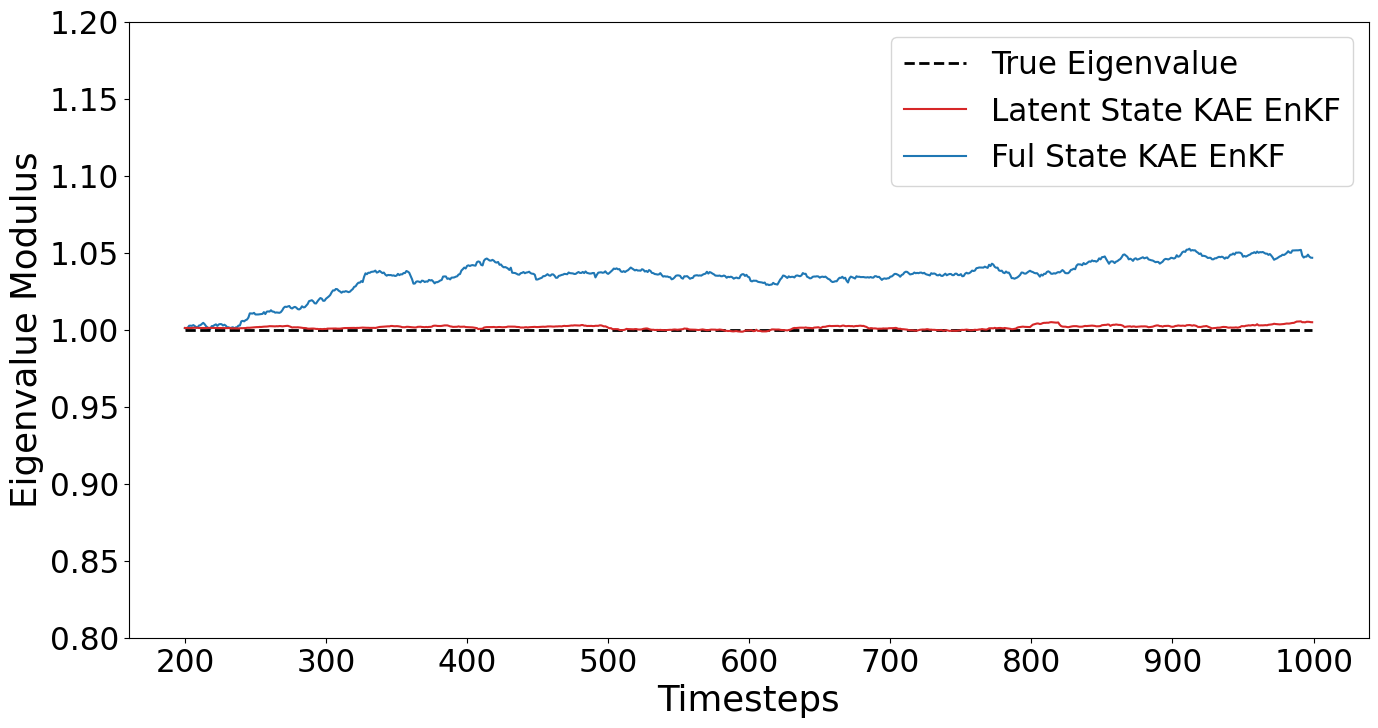

In [14]:
num_to_keep = num_data-num_spinup
x = range(200,1000)
plt.plot(x,np.ones(num_to_keep),label='True Eigenvalue',c='black',linewidth='2', ls='--',zorder=3)
plt.plot(x,[x[-2] for x in kaeenkf.X][-num_to_keep:],label='Latent State KAE EnKF',c='tab:red',zorder=3)
plt.plot(x,[x[-2] for x in kaeenkf2.X][-num_to_keep:],label='Ful State KAE EnKF',c='tab:blue',zorder=2)
plt.legend()
plt.ylim(0.8, 1.2)
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Modulus')
#plt.savefig('graphs/0.05_latent_fullstate_kaeenkf_eigmod_trajectory.png',bbox_inches='tight')

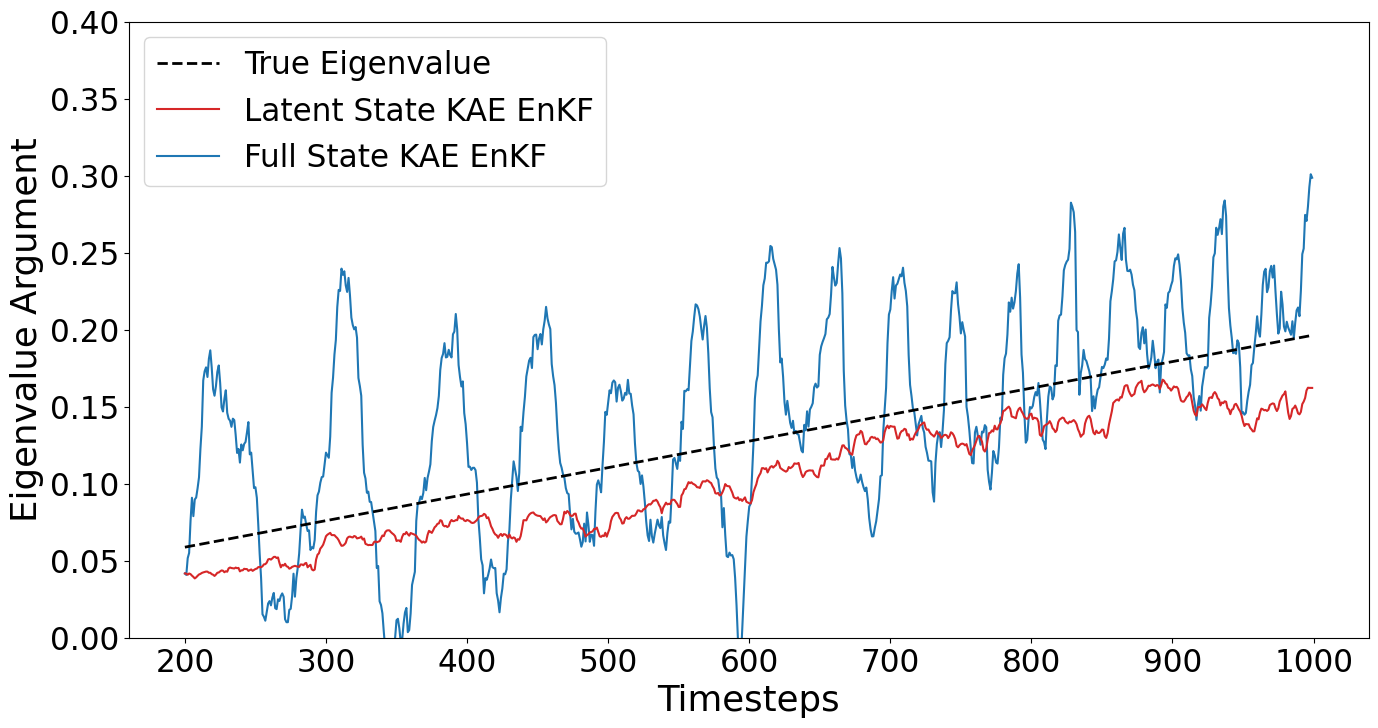

In [15]:
num_to_keep = num_data-num_spinup
plt.plot(x,dataset.thetas[-num_to_keep:],c='black',linewidth='2', ls='--',zorder=3,label='True Eigenvalue')
plt.plot(x,[abs(2*np.pi - x[-1]) if x[-1]>np.pi else x[-1] for x in kaeenkf.X][-num_to_keep:],
         label='Latent State KAE EnKF', c='tab:red',zorder=3)
plt.plot(x,[abs(2*np.pi - x[-1]) if x[-1]>np.pi else x[-1] for x in kaeenkf2.X][-num_to_keep:],
         label='Full State KAE EnKF', c='tab:blue',zorder=2)
plt.legend()
plt.ylim(0, 0.4)
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
#plt.savefig('graphs/0.05_latent_fullstate_kaeenkf_eigarg_trajectory.png',bbox_inches='tight')